In [2]:
import anndata as ad
import scanpy as sc
from sklearn.model_selection import train_test_split
import pylab as pl
import seaborn as sns
from limix_core.util.preprocess import gaussianize, regressOut
import scipy.stats as st
from mtgwas import VCTEST
from sklearn.impute import SimpleImputer
import scipy.linalg as la
from mtgwas.utils import df_match
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from os.path import join

In [12]:
%load_ext autoreload
%autoreload 2

In [44]:
tissue = 'Thyroid'
outdir = f'visualization/{tissue}'
os.makedirs(outdir, exist_ok=True)

In [5]:
#Reading the anndata
hfile = f"/lustre/groups/casale/datasets/gtex/histology/20230425_v2_tiles/stage2/{tissue}/embedding/summary_scanpy_pc.h5ad"
idata = ad.read_h5ad(hfile)

In [88]:
_ = idata.obs['slide'].str.split('-')
idata.obs['SID'] = _.str.get(0) + '-' + _.str.get(1)

<ipython-input-88-984fcb40a68f>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  idata.obs['SID'] = _.str.get(0) + '-' + _.str.get(1)


In [7]:
dfX = idata.to_df()
dfX['SID'] = idata.obs['SID'].values
dfX = dfX.groupby('SID').mean()

In [31]:
# Simulate a trait to visualize its direction
snp_df = pd.DataFrame(np.random.rand(dfX.shape[0], 1))
snp_df.index = dfX.index


In [33]:
X = dfX.values
y = snp_df.values
F = np.zeros((dfX.shape[0], 1))

In [34]:
#regressing out the covariates from the embeddings
yr = regressOut(y, F)
Xr = regressOut(X, F)

In [35]:
# fit variant component model
vc = VCTEST()
res = vc.fit(Xr, yr)
ystar = vc.predict_loo()

100%|██████████| 100/100 [00:00<00:00, 1286.26it/s]


In [36]:
# getting direction for each of the images
idata.obs['ystar'] = vc.predict(idata.X).ravel()

# Working on PGAN for interpolation

### Note below interpolation was done on simulated trait

In [20]:
import sys

from torchvision.utils import make_grid
import json
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import torch

os.chdir('/lustre/groups/casale/code/users/shubham.chaudhary/projects/AIH-SGML/HistoGWAS/PGAN')
from models.progressive_gan import ProgressiveGAN as PGAN

In [21]:
class Generator():
    
    def __init__(self, config, checkpoint, useGPU=True):
        with open(config, 'rb') as file:
            config = json.load(file)
        self.pgan = PGAN(useGPU=useGPU, storeAVG=True, **config)
        self.pgan.load(checkpoint)
        self.netG = self.pgan.netG
        self.device = self.pgan.device
        
    def forward(self, x, eps=None):
        if eps is None:
            eps = torch.randn(x.shape[0], 512)
        if type(x)==np.ndarray:
            x = torch.Tensor(x)
        if type(eps)==np.ndarray:
            eps = torch.Tensor(eps)
        x = x.to(self.device)
        eps = eps.to(self.device)
        with torch.no_grad():
            out = self.netG(eps, x).data.cpu()
            out = 0.5 * (out + 1)
            out = torch.clip(out, 0, 1)
        return out
    
def load_image_torch(path, size):
    if type(path) in [list, np.ndarray]:
        return torch.cat([load_image_torch(_, size) for _ in path])
    return pil_to_tensor(Image.open(path).resize((size, size)))[None] / 255.


def torch_imshow(x):
    pl.imshow(x.permute(1, 2, 0))

In [24]:
config = '/lustre/groups/casale/code/users/shubham.chaudhary/projects/AIH-SGML/HistoGWAS/PGAN/config/config.json'
checkpoint = '/lustre/groups/casale/code/users/shubham.chaudhary/output/projects/gtex/PGAN/Thyroid_test/Thyroid/Thyroid_s6_i32000.pt'
generator = Generator(config, checkpoint, useGPU=True)

Average network found !


In [37]:
# Getting the top and the bottom embedding to be used for interpolation

outliers = 0.01
extreme = 0.05
q1, q2, Q1, Q2 = np.quantile(idata.obs['ystar'].values, [outliers, extreme, 1 - extreme, 1 - outliers])
Ih1 = np.logical_and(idata.obs['ystar'].values>Q1, idata.obs['ystar'].values<Q2)
Il1 = np.logical_and(idata.obs['ystar'].values>q1, idata.obs['ystar'].values<q2)

# interpolates
emb1 = idata.X[Il1].mean(0)[None]
emb2 = idata.X[Ih1].mean(0)[None]

In [45]:
outdir

'visualization/Thyroid'

In [47]:
for i in range(1):   # This are different realization of the same embedding
    inter = np.linspace(0, 1, 8)[:, None]
    Embs = emb1 * (1 - inter) + emb2 * inter
    Eps = np.random.randn(1, 512) * np.ones([Embs.shape[0], 1])
    Xinter = generator.forward(Embs, Eps)
    
    outdir_temp = join(outdir, f'realization_{i}')
    os.makedirs(outdir_temp, exist_ok=True)
    images = []
    for idx,img in enumerate(Xinter):
        img = to_pil_image(img)
        outfile = join(outdir_temp, f'{idx}_{tissue}.PNG')
        # img.save(outfile)
        
        images.append(img)
    images_forward = images
    images_backward = images[::-1]  # Reverse the order of frames

    looped_frames = images_forward + images_backward[1:]
    
    
    os.makedirs(outdir, exist_ok=True)
    gif_file = f"{tissue}_interpolation_{i}.gif"
    outfile = join(outdir, gif_file)
    looped_frames[0].save(outfile, save_all=True, append_images=looped_frames[1:], loop=0)
  
    
Xinter_grid = make_grid(Xinter, nrow=8)

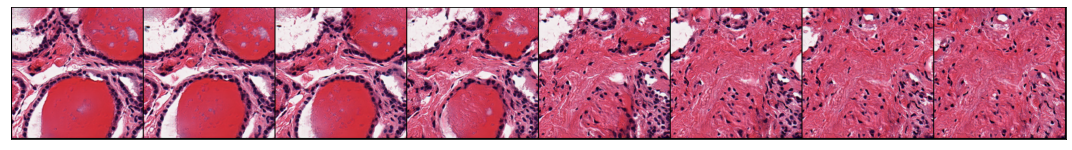

In [42]:
# Doing the projection
pl.figure(1, figsize=(15, 15))
plt = pl.subplot(111)
torch_imshow(Xinter_grid)
plt.set_xticks([])
plt.set_yticks([])
pl.tight_layout()
# pl.savefig(f'{figdir}/randomsamples.png', dpi=300)